# Set up the working directory and enviroment

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/combined1_hNIL")

FileNotFoundError: ignored

## Assign folders for storing input data, object, and output
1. 'data' folder: storing .mtx or h5 from 10xGenomic sequencing 
2. 'interim' folder: storing h5ad object after processing and its output files, e.g., top_markers.csv
3. 'figures' folder: automatically generated

In [3]:
%ls

drive/  sample_data/


In [ ]:
#! mkdir scanpy_out
results_file = 'scanpy_out/combined1_hNIL.h5ad'

## Installed the required packages

In [ ]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc

## Set up the displaying and print parameters

In [ ]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0


# Data preprocessing
1. Use gene symbols for the variable names (variables-axis index)
3. Write a cache file for faster subsequent reading
4. De-duplicates

## Read 10xGenomics sc-RNA sequencing data

In [ ]:
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")                               

reading filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:03)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
adata.var_names_make_unique()

In [ ]:
adata

AnnData object with n_obs × n_vars = 6202 × 33538 
    var: 'gene_ids', 'feature_types', 'genome'

## Basic filtering
1. cell based filtering: remove cells with less than 200 genes
2. gene based filtering: remove genes expressing in less than 3 cells

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 13692 genes that are detected in less than 3 cells


## Calculate the percentage of mitochondrial genes

In [ ]:
mito_genes = adata.var_names.str.startswith('MT-')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

## Check sequencing quality
1. choose the threthold of gene numbers to remove, e.g., n_genes = 4500
2. choose the threthold of mitochondial genes to remove, e.g., percent_mito = 0.15

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
... storing 'feature_types' as categorical
... storing 'genome' as categorical


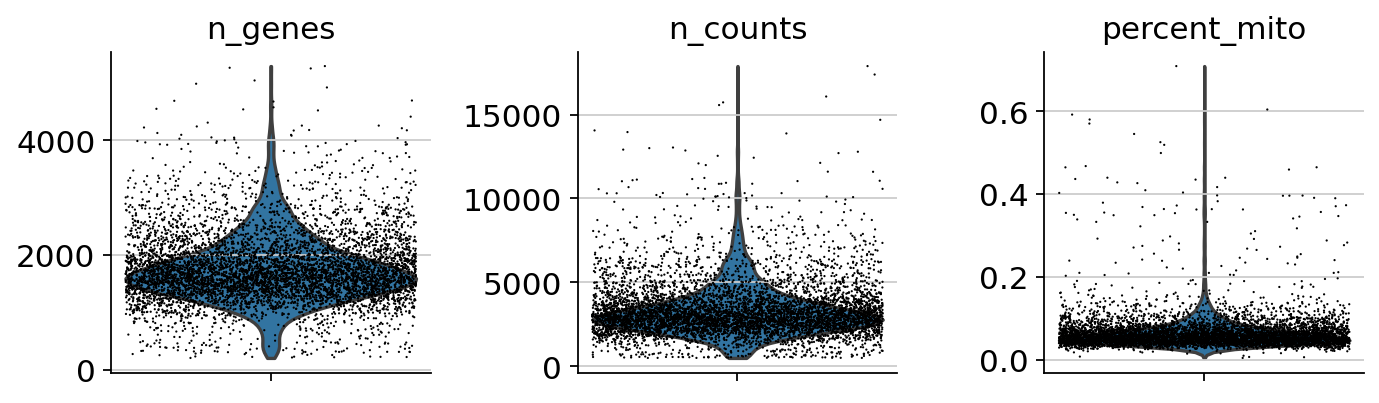

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

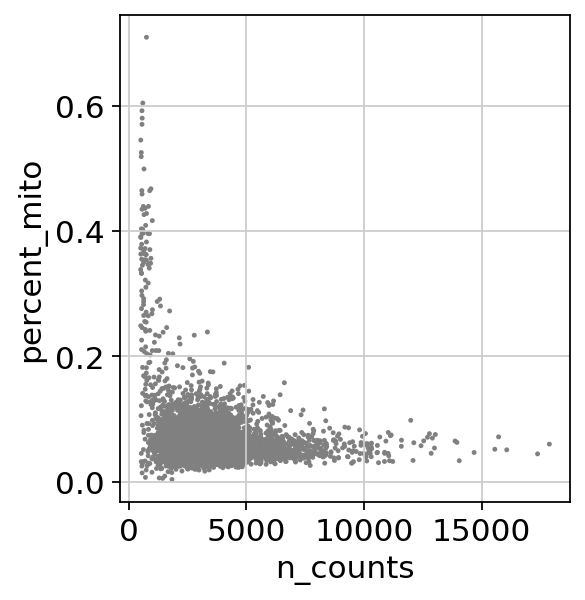

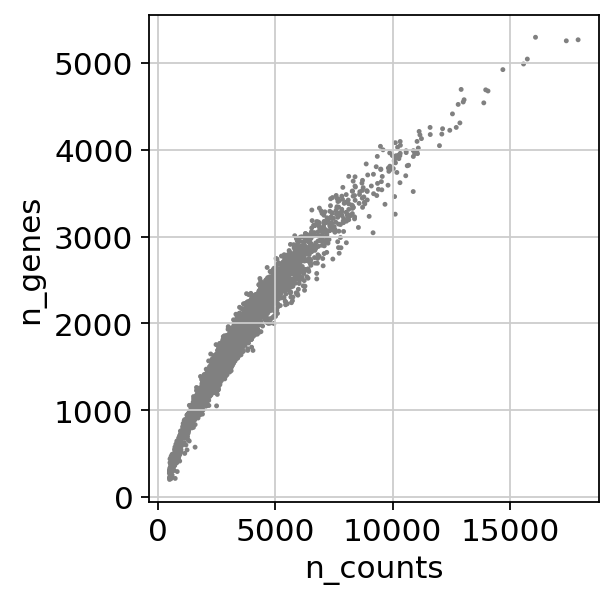

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata = adata[adata.obs.n_genes < 4500, :]
adata = adata[adata.obs.percent_mito < 0.15, :]
adata

View of AnnData object with n_obs × n_vars = 6038 × 19846 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Scale and logarithmize the data
option: store the unnormalized data in .raw

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata

normalizing counts per cell
    finished (0:00:10)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Choosing highly-variable genes for further analysis
Subset is optional. If subset using adata.var.highly_variable, the adata will only contain these genes.

This time, let's try do not subset

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


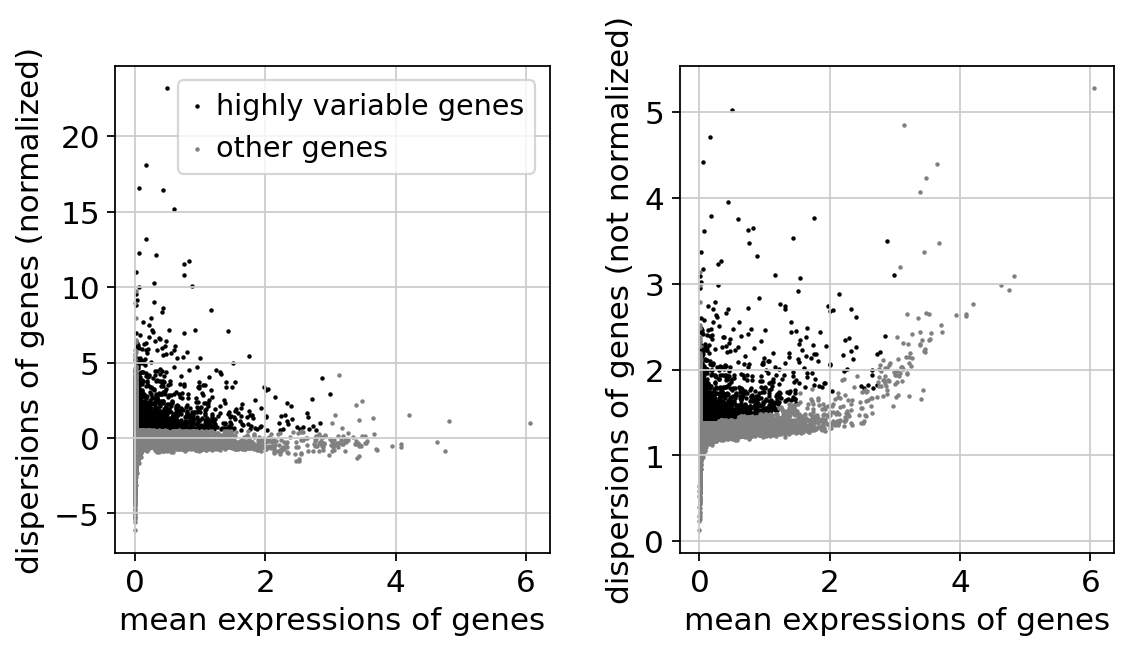

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 6038 × 2183 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Further scale on cofounder "n_counts" and "percent_mito"
1. Regression out n_counts and percent_mito effect and scale again on adata which only contains highly-variable genes now.
2. Clip values exceeding standard deviation 10 (max_value=10)

In [ ]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:17)


# Principal component analysis

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:02)


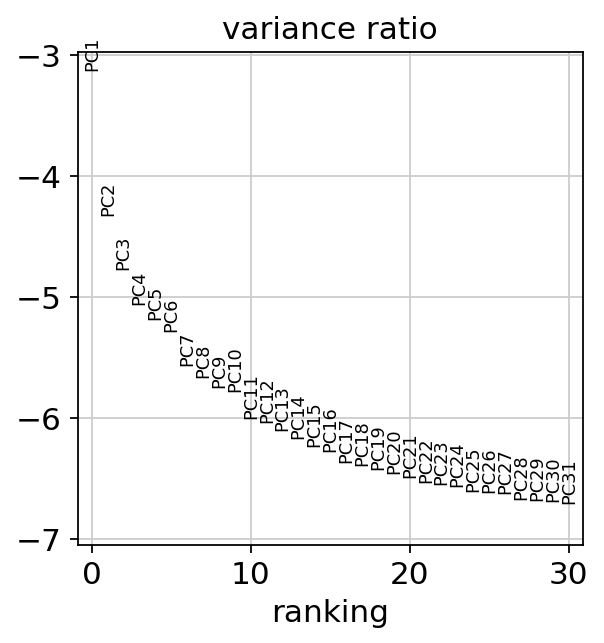

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
!pwd

/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/combined1_hNIL


In [ ]:
adata.write_h5ad("scanpy_out/combined1_hNIL_before_neighbors.h5ad")


### Computing, embedding, and clustering the neighborhood graph

1. Computing the neighborhood graph of cells using the PCA representation of the data matrix.
2. Embedding the graph in 2 dimensions using UMAP.
3. Clustering the neighborhood graph using Leiden graph-clustering method 

In [ ]:
 # defaults are: n_neighbors= 20, n_pcs=50
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


In [ ]:
# default resolution=1.0
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [ ]:
adata

AnnData object with n_obs × n_vars = 6038 × 2183 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [ ]:
sc.tl.leiden(adata, resolution=0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution=0.6, key_added = "leiden_0.6")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:01)


## Visualize the clusters

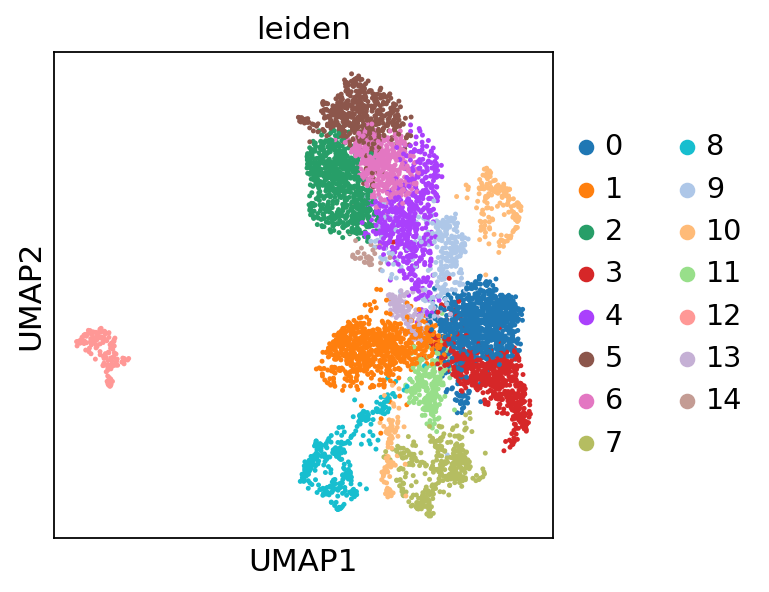

In [ ]:
sc.pl.umap(adata, color=['leiden'])

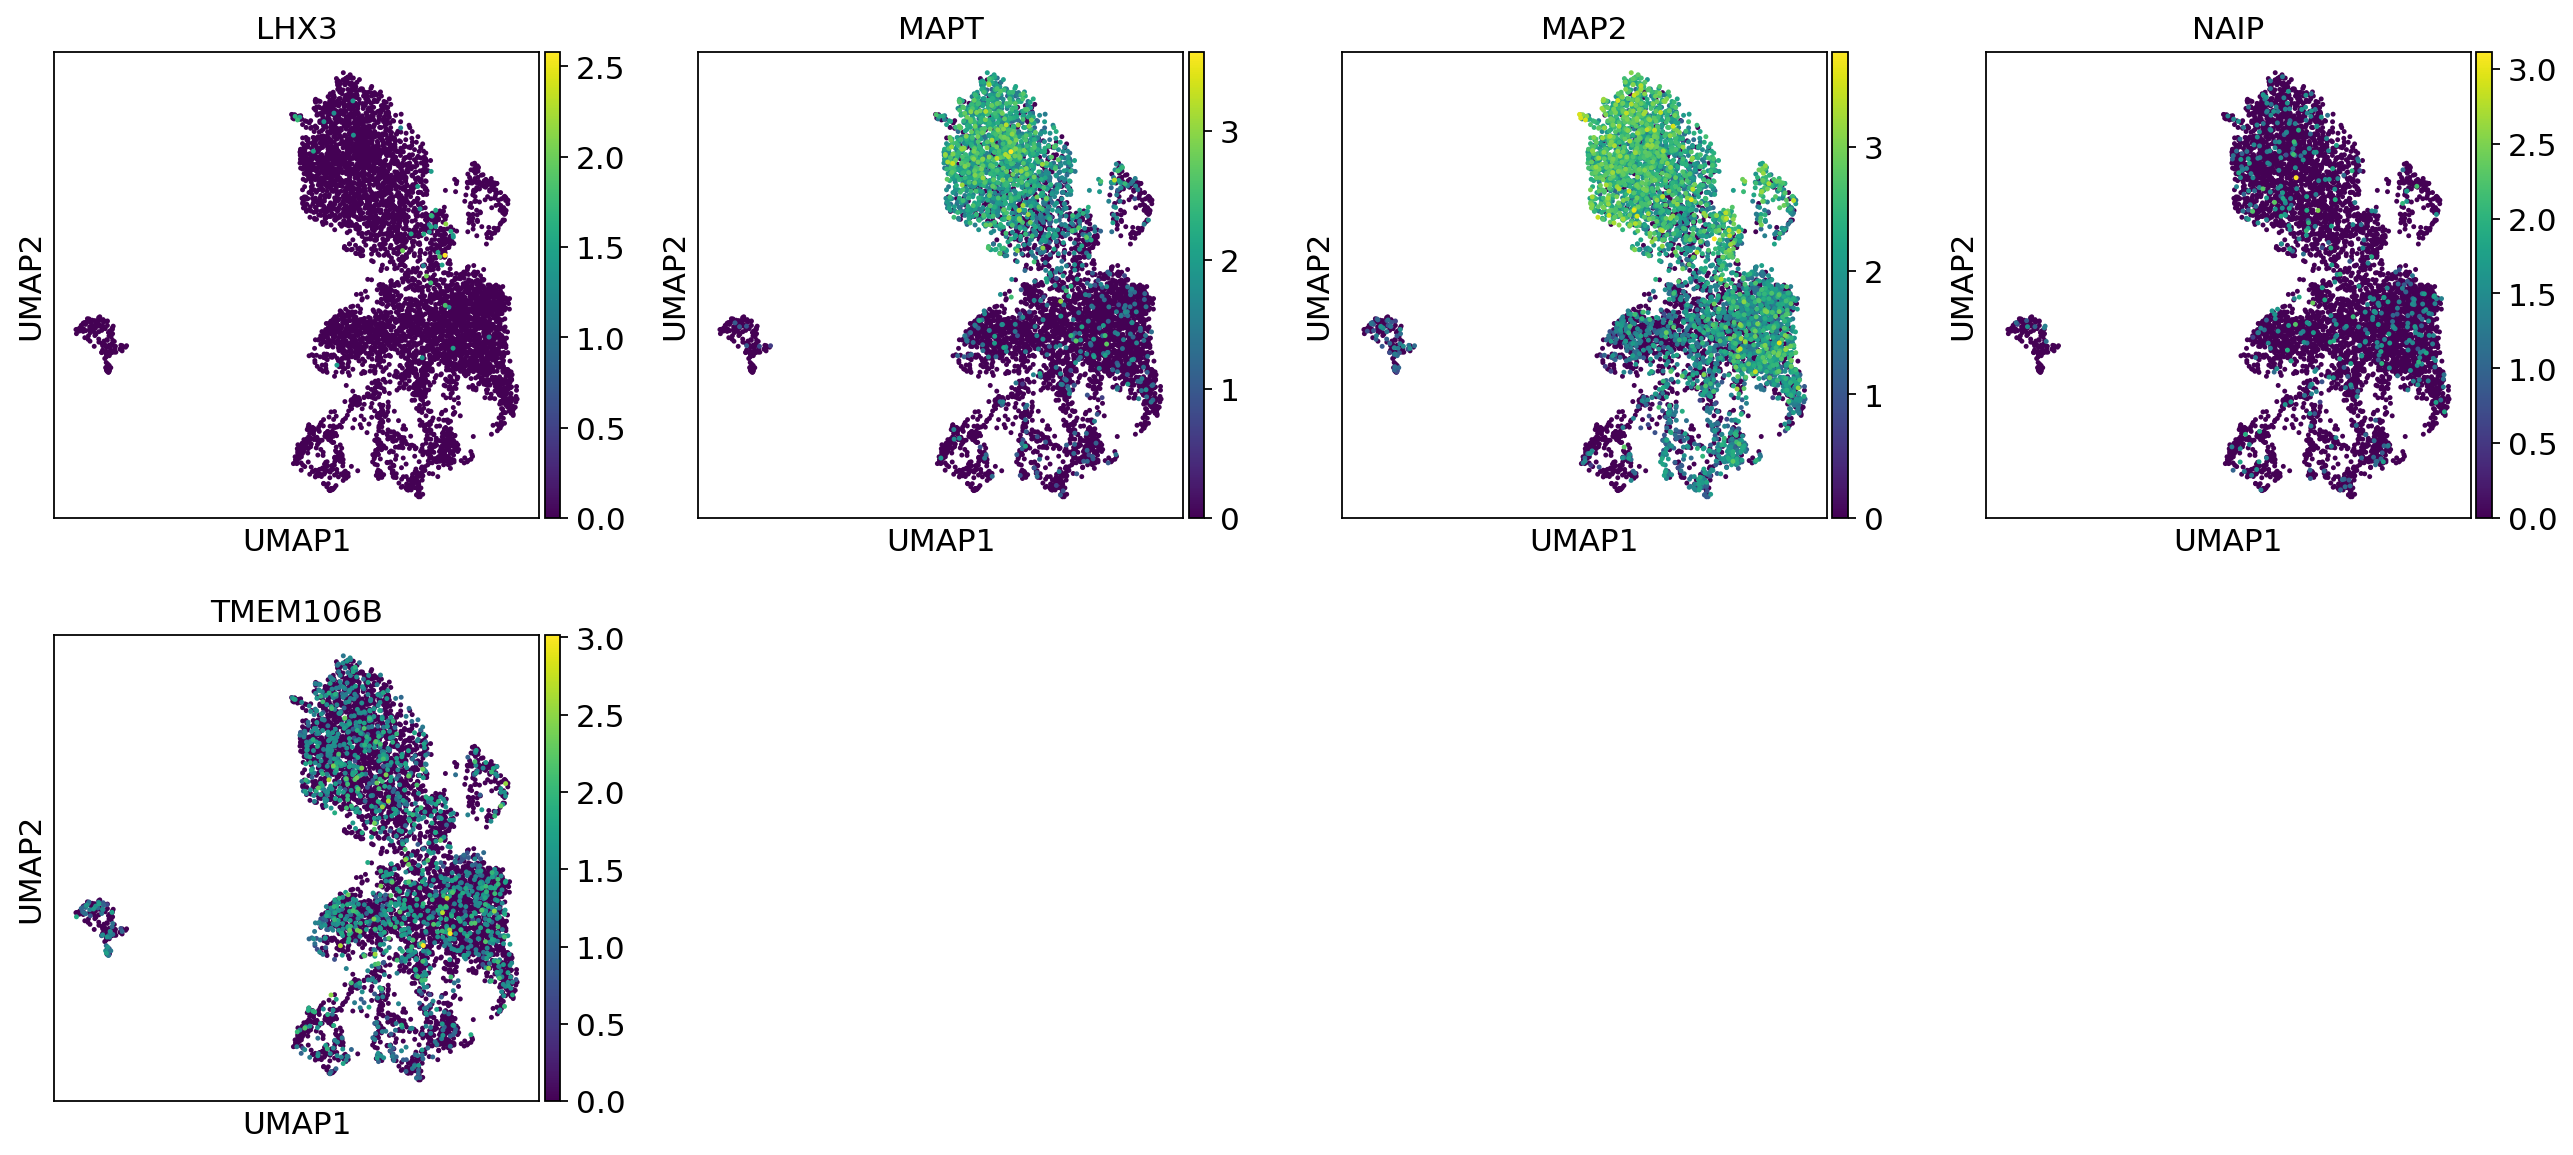

In [ ]:
# motor neuron related genes
# LHX3: a transcription factor that is required for pituitary development and motor neuron specification
sc.pl.umap(adata, color=['LHX3','MAPT','MAP2', 'NAIP', 'TMEM106B'])

## Save the processed adata object saved as .h5ad
The object can be load using adata = sc.read(results_file)

In [ ]:
adata.write(results_file)

# Finding marker genes
one vs rest comparison using Mann-Whitney-U-test (recommend)

In [ ]:
# reduce the verbosity from 3 to 2 in the setting of logging output
sc.settings.verbosity = 2 

ranking genes
    finished (0:00:09)


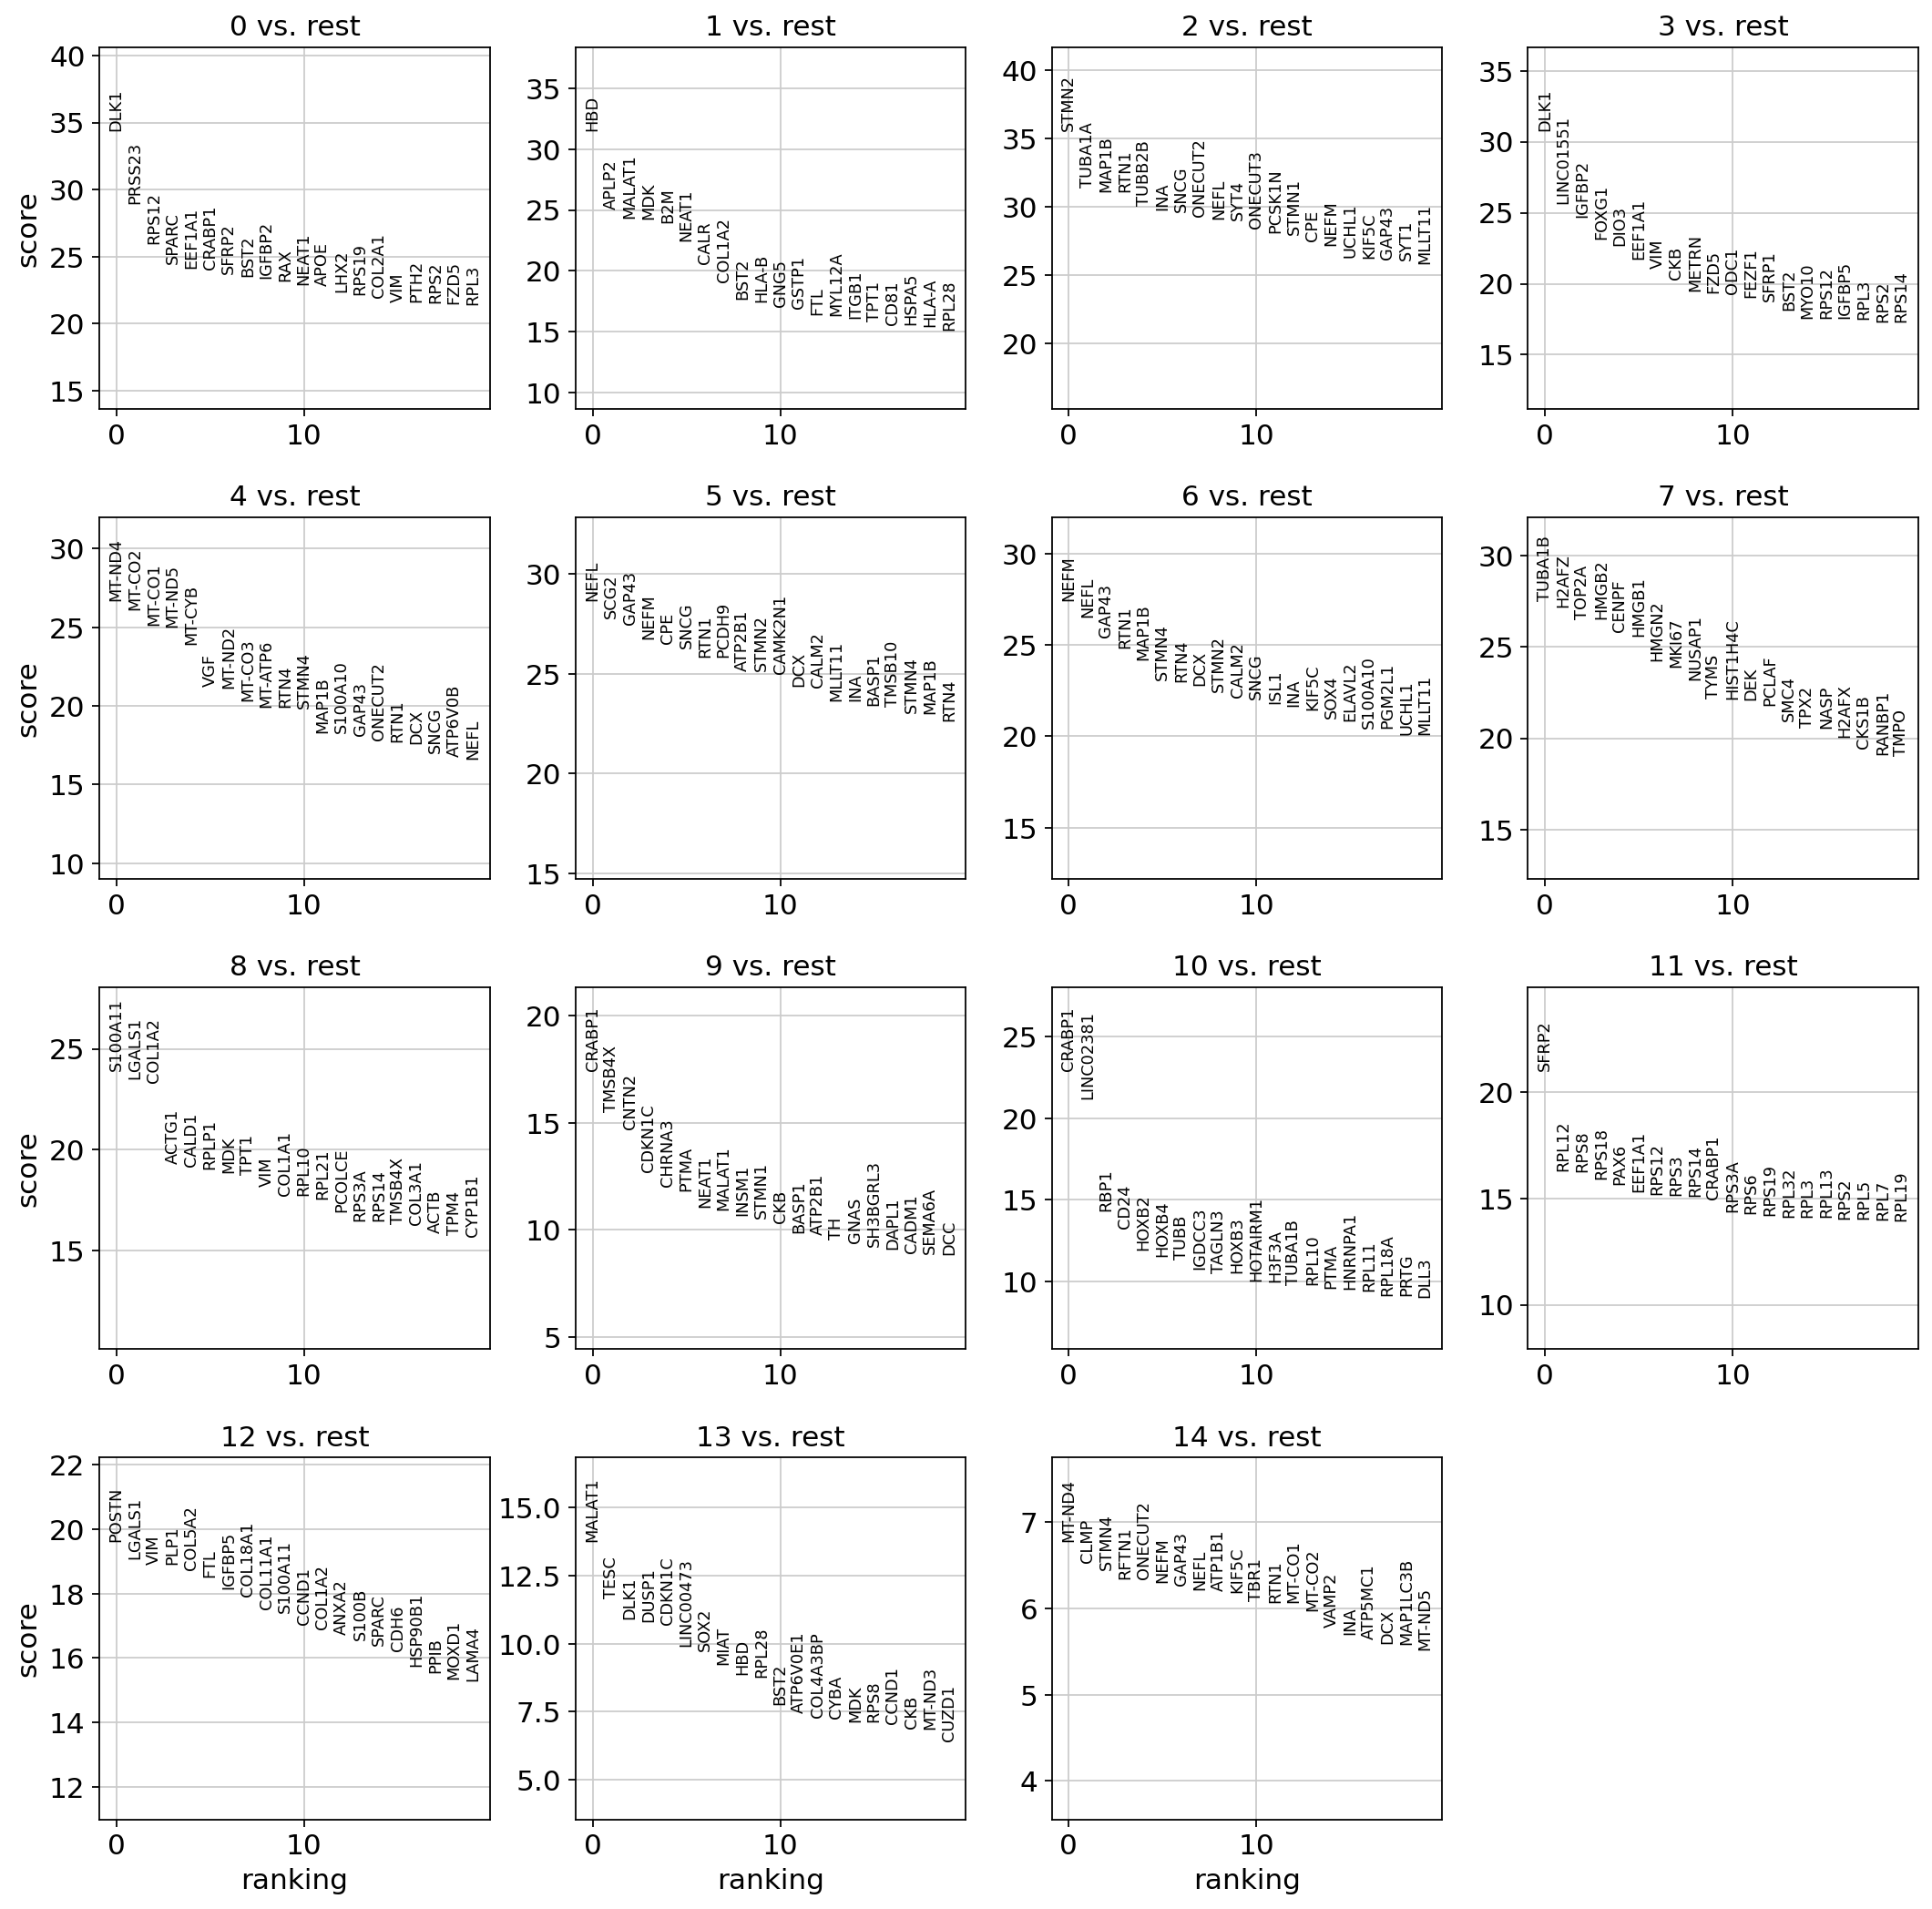

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Visualize the differential expression of marker genes across clusters
1. Differential expression a set of marker genes of a specific cluster vs the rest.
2. Differential expression of a single gene across all clusters

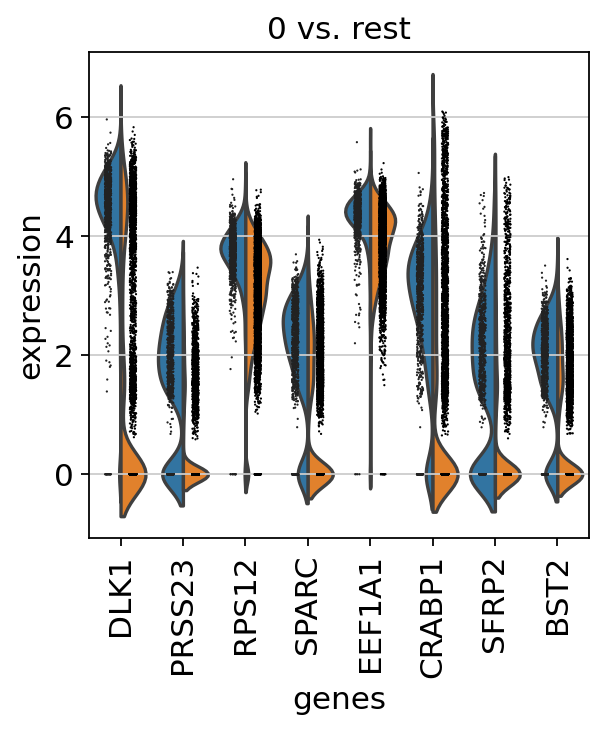

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

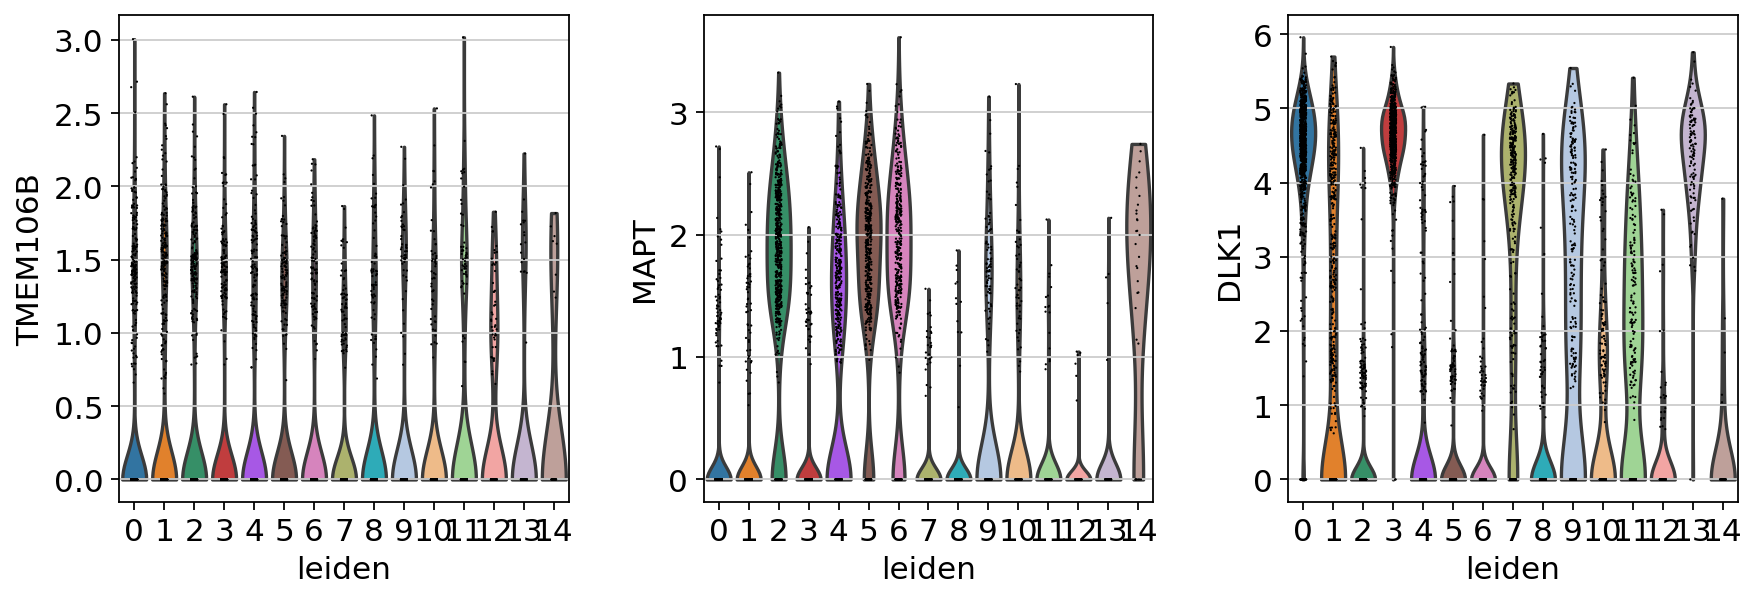

In [ ]:
sc.pl.violin(adata, ['TMEM106B', 'MAPT', "DLK1"], groupby='leiden')

## Annotate cell types for all the clusters 
Based on domain knowledge and information of marker genes

Wait for disscussion for this case


In [ ]:
# assign cell type names to the clusters
# new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']

# adata.rename_categories('leiden', new_cluster_names)

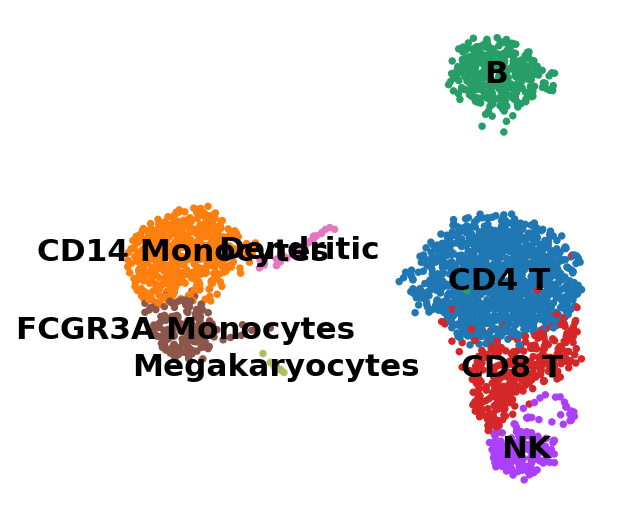

In [ ]:
# it automatically generates a folder of 'figures' and save the figure inside 
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

# Export a list of marker genes

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

top_marker_genes.to_csv('scanpy_out/top_markers_combined1_hNIL.csv')

In [ ]:
top_marker_genes.head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p
0,DLK1,3.574325e-259,HBD,6.501520e-218,STMN2,4.486793e-277,DLK1,6.381355e-208,MT-ND4,8.979605e-157,NEFL,1.467688e-180,NEFM,2.235186e-165,TUBA1B,1.044193e-166,S100A11,2.955622e-126,CRABP1,6.393683e-68,CRABP1,4.453495e-116,SFRP2,1.104165e-97,POSTN,8.792046e-86,MALAT1,4.053478e-43,MT-ND4,1.216243e-11
1,PRSS23,1.135187e-184,APLP2,1.737194e-138,TUBA1A,1.636772e-216,LINC01551,3.582138e-145,MT-CO2,4.871509e-150,SCG2,5.626777e-170,NEFL,6.288806e-155,H2AFZ,1.265635e-162,LGALS1,2.057132e-122,TMSB4X,2.939435e-54,LINC02381,2.053890e-99,RPL12,1.365153e-59,LGALS1,4.952975e-81,TESC,1.950587e-31,CLMP,6.686616e-11
2,RPS12,3.570176e-148,MALAT1,7.245175e-131,MAP1B,1.211582e-212,IGFBP2,1.148068e-134,MT-CO1,2.378643e-139,GAP43,3.018023e-166,GAP43,1.165855e-142,TOP2A,2.480995e-155,COL1A2,2.752309e-120,CNTN2,6.709387e-49,RBP1,1.871213e-46,RPS8,2.272926e-59,VIM,8.300286e-80,DLK1,9.801249e-28,STMN4,1.111831e-10
3,SPARC,6.944001e-132,MDK,9.997186e-130,RTN1,3.228398e-212,FOXG1,2.450385e-118,MT-ND5,1.074846e-137,NEFM,8.720262e-158,RTN1,7.804966e-136,HMGB2,7.900450e-155,ACTG1,4.822950e-83,CDKN1C,6.517236e-37,CD24,3.748380e-40,RPS18,7.555245e-57,PLP1,8.599030e-80,DUSP1,3.687355e-27,RFTN1,2.293519e-10
4,EEF1A1,1.475545e-128,B2M,1.108311e-126,TUBB2B,2.832763e-199,DIO3,6.893642e-114,MT-CYB,2.905768e-126,CPE,9.387862e-155,MAP1B,6.585513e-129,CENPF,4.648971e-147,CALD1,4.535294e-82,CHRNA3,1.907188e-33,HOXB2,1.167656e-32,PAX6,3.293378e-55,COL5A2,1.889368e-78,CDKN1C,1.049799e-26,ONECUT2,2.297306e-10


In [ ]:
# get a list of top20 marker genes of cluster 1
marker_genes_cluster1 = top_marker_genes["1_n"][:20].values

# Visulize gene differential expression 
maker genes or other gene of interest


In [ ]:
ax = sc.pl.dotplot(adata, marker_genes_cluster1, groupby='leiden')

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes_cluster1, groupby='leiden', rotation=90)

NameError: ignored

# Save the work
option: export a set of csv using 
adata.write_csvs(results_file[:-5])

In [ ]:
adata.write(results_file)

In [ ]:
%ls

analysis_10xgenomics/        filtered_feature_bc_matrix.h5  scanpy_out/
barcodes.tsv.gz              possorted_genome_bam.bam       web_summary.html
filtered_feature_bc_matrix/  possorted_genome_bam.bam.bai
